In [1]:
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint


In [2]:
# Rossler System
def Rossler(xi, t):
    a = 0.2
    b = 0.2
    c = 5.7
    
    (x,y,z) = xi

    dx = -y - z
    dy = x + a * y
    dz = b + z * ( x - c )

    return np.array( [dx,dy,dz] )

def RosslerP(xi, t, a, b, c):    
    (x,y,z) = xi

    dx = -y - z
    dy = x + a * y
    dz = b + z * ( x - c )

    return np.array( [dx,dy,dz] )

def Lorenz(xi,t):
    rho = 25.0
    sigma = 10.0
    beta = 8.0 / 3.0
    
    (x,y,z) = xi
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def LorenzP(xi,t, rho, sigma, beta):
    
    (x,y,z) = xi
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def Lorenz96(x, t):
    N = 5 # dimension
    F = 8

    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d    

def LorenzYang(xi, t):
    k1 = lambda t : -0.01*(t**2)
    k2 = lambda t : 0.01*t
    k3 = lambda t : 0.01*t
    k4 = lambda t : -0.01*(t ** 2)

    rho = 28.0
    sigma = 10.0
    beta = 8.0 / 3.0
    
    (x,y,z) = xi
    return -sigma*(x-y)+k1(t)*y, rho*x-y-x*z+k2(t)*z, -beta*z+x*y+(k3(t)+k4(t))*y  # Derivatives

In [3]:
def delayEmbed(Xin, Yin,assignment,embInterval):
    
    tmplen = Xin.shape[1]

    tmp = np.zeros([sum(x) for x in zip(Xin.shape,(0,sum(assignment)))])
    tmp[:,:Xin.shape[1]] = Xin
    Xin = tmp

    lag = 1
    newColInd = 0
    if len(assignment) != tmplen:
        print("Assigment list doesn't match the number of variables in data array! ",assignment)
        return
    else:
        # code that creates the lags
        for i in range(len(assignment)):
            for _ in range(assignment[i]):
                newCol = Xin[:-embInterval*lag,i]
                Xin[embInterval*lag:, tmplen + newColInd] = newCol
                newColInd += 1
                lag += 1
    Xin = Xin[embInterval*sum(assignment):]
    Yin = Yin[embInterval*sum(assignment):]
    
    # Yin = Yin[-X.shape[0]:]
    
    return (Xin, Yin)

In [4]:
begin = 0
end = 100
step = 0.05
tlen = int((end-begin)/step)
trainToTest = 0.5 # between 0 and 1
t = np.arange(begin, end, step)

# MAKE SURE TO UPDATE THE DIMENSION WHEN SWITCHING ATTRACTORS
dim = 3
# t0 = np.array([0.5])
t0 = np.ones(dim) * 0.5 # np.array([0,5,15]) * 1 # np.zeros(dim)
t0[0] += 0.1

In [5]:
# STATIONARY SIMULATION VERSION: UPDATE ATTRACTOR YOU WANT HERE
#               \/\/\/\/
# X = odeint(Lorenz,t0,t)

# NON STATIONARY VERSION
"""
# Lorenz
rho = lambda t : 28 + 4 * np.sin( 4 * 2*np.pi * t / (tlen-2))# (2*np.heaviside(t-500, 1)-np.heaviside(t-1000, 1)) # rho = 28.0
# sigma = 10       # sigma = 10.0
sigma = lambda t : 10.0 # np.sin( 4 * 2*np.pi * t / (tlen-2))
beta = lambda t : 8.0 / 3.0  # beta = 8.0 / 3.0

largs = lambda t : (rho(t), sigma(t), beta(t))

states = np.zeros((tlen,3))
states[0] = t0
for i in range(1, tlen ):
    # print(largs(i))
    states[i] = odeint(LorenzP,states[i-1],np.array([t[i-1],t[i]]),args=largs(i))[1,:]
X = states
"""

# Rossler
a = lambda t : 28 + 4 * np.sin( 4 * 2*np.pi * t / (tlen-2))# (2*np.heaviside(t-500, 1)-np.heaviside(t-1000, 1)) # rho = 28.0
# sigma = 10       # sigma = 10.0
b = lambda t : 10.0 # np.sin( 4 * 2*np.pi * t / (tlen-2))
c = lambda t : 8.0 / 3.0  # beta = 8.0 / 3.0

largs = lambda t : (a(t), b(t), c(t))

states = np.zeros((tlen,3))
states[0] = t0
for i in range(1, tlen ):
    # print(largs(i))
    states[i] = odeint(RosslerP,states[i-1],np.array([t[i-1],t[i]]),args=largs(i))[1,:]
X = states

# END NON STATIONARY

In [6]:
# Logistic Map
"""
# r = lambda t : 0.6 * np.sin(4*2*np.pi*t/tlen) + 3.4
r = lambda t : 0.5 * t / tlen + 3.5
states = np.zeros((tlen,1))
states[0,0] = t0
for t in range(1,tlen):
    states[t,0] = r(t) * states[t-1,0] * (1 - states[t-1,0])
X = states


# Density Dependent Maturation
states = np.ones((tlen, 2))
s = 0.02
gamma = 0.01
sA = 0.1
sJ = 0.5
b = 35
# Gmax = 0.9
# g = lambda x : Gmax*np.exp(-gamma*x)
# Gmax = lambda t : 0.25 + t * 0.74 / (tlen-2) # LINEAR GMAX
# Gmax = lambda t : 0.75 + 0.25 * np.sin( 4 * 2 * np.pi * t / (tlen-2)) # PERIODIC
Gmax = lambda t : 0.75
g = lambda x , t: Gmax(t)*np.exp(-gamma*x)
states[0] = np.array([5,300])
for i in range(0,tlen-1):
    At = states[i,0]
    Jt = states[i,1]
    zt = rand.normal(-s/2, s) # rand.normal(0,s) # vs rand.normal(-(s**2)/2, s)
    # m = np.array([[sA, sJ*g(At+Jt)],[b*np.exp(zt), sJ*(1-g(At+Jt))]])
    m = np.array([[sA, sJ*g(At+Jt,i)],[b*np.exp(zt), sJ*(1-g(At+Jt,i))]])
    states[i+1] = m @ states[i].T
X = states
"""

'\n# r = lambda t : 0.6 * np.sin(4*2*np.pi*t/tlen) + 3.4\nr = lambda t : 0.5 * t / tlen + 3.5\nstates = np.zeros((tlen,1))\nstates[0,0] = t0\nfor t in range(1,tlen):\n    states[t,0] = r(t) * states[t-1,0] * (1 - states[t-1,0])\nX = states\n\n\n# Density Dependent Maturation\nstates = np.ones((tlen, 2))\ns = 0.02\ngamma = 0.01\nsA = 0.1\nsJ = 0.5\nb = 35\n# Gmax = 0.9\n# g = lambda x : Gmax*np.exp(-gamma*x)\n# Gmax = lambda t : 0.25 + t * 0.74 / (tlen-2) # LINEAR GMAX\n# Gmax = lambda t : 0.75 + 0.25 * np.sin( 4 * 2 * np.pi * t / (tlen-2)) # PERIODIC\nGmax = lambda t : 0.75\ng = lambda x , t: Gmax(t)*np.exp(-gamma*x)\nstates[0] = np.array([5,300])\nfor i in range(0,tlen-1):\n    At = states[i,0]\n    Jt = states[i,1]\n    zt = rand.normal(-s/2, s) # rand.normal(0,s) # vs rand.normal(-(s**2)/2, s)\n    # m = np.array([[sA, sJ*g(At+Jt)],[b*np.exp(zt), sJ*(1-g(At+Jt))]])\n    m = np.array([[sA, sJ*g(At+Jt,i)],[b*np.exp(zt), sJ*(1-g(At+Jt,i))]])\n    states[i+1] = m @ states[i].T\nX = stat

In [7]:
# Read input data from files
"""
file = "paramecium_didinium - cleaned.csv"
data = pd.read_csv(file,encoding="utf-8",na_filter=False)
X = data.to_numpy()
print(X)
"""

'\nfile = "paramecium_didinium - cleaned.csv"\ndata = pd.read_csv(file,encoding="utf-8",na_filter=False)\nX = data.to_numpy()\nprint(X)\n'

In [8]:
X, _ = delayEmbed(X, X, [5,5,5],1)

In [9]:
# X = (X - X.mean(0) ) / X.std(0) # normalize
print(X)

[[ -7.46196111  -9.16071259  25.82522048 ...   0.49361769   0.46539222
    0.5       ]
 [ -8.27189088  -9.82010032  26.10880296 ...   0.70675085   0.49361769
    0.46539222]
 [ -9.00038738 -10.33333383  26.94535055 ...   1.49756146   0.70675085
    0.49361769]
 ...
 [  0.56035073  -0.08734367  19.068347   ...  15.1939991   16.94874382
   19.11467251]
 [  0.35429589   0.13237073  16.68854997 ...  13.9575649   15.1939991
   16.94874382]
 [  0.30708571   0.32005173  14.60877036 ...  13.50957809  13.9575649
   15.1939991 ]]


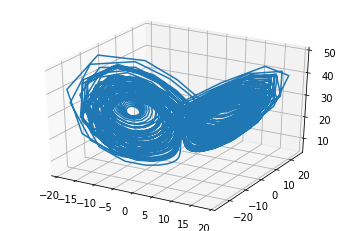

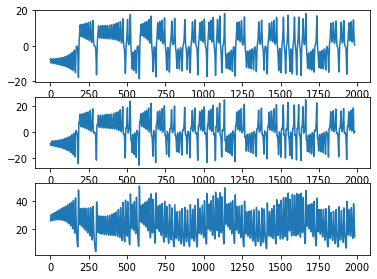

In [10]:
fig2 = plt.figure(2)
if dim == 1:
    ax2 = plt.subplot()
    ax2.plot(X[:,0],"b") # states
elif dim == 2:
    ax2 = plt.subplot()
    ax2.plot(X[:,0],X[:,1])
else:
    ax2 = fig2.gca(projection="3d")
    ax2.plot(X[:,0],X[:,1],X[:,2])
    
    
figTS, axTS = plt.subplots(dim,figsize=(6,dim*1.5))
for i in range(dim):
    axTS[i].plot(X[:,i])

plt.show()

1985


<Figure size 432x288 with 0 Axes>

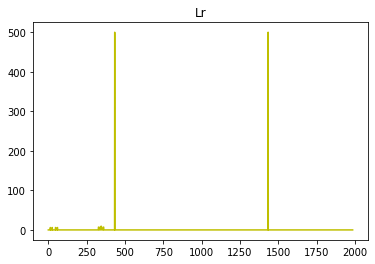

In [11]:
def lr(X,r):
    # increase the border e depending on one std distance in given dimension
    global dim 
    e = 0.5 * ((dim) ** 0.5)
    
    ind = e > la.norm(X - X[r],axis=1)
    
    neighbors = X[ind]
    neighborIndexes = np.arange(0,X.shape[0],1)[ind]
    
    l_r = np.sum(np.absolute(neighborIndexes - r)) / neighborIndexes.shape[0]
    
    return l_r
print(X.shape[0])
LR = np.zeros((X.shape[0]))
for i in range(X.shape[0]):
    LR[i] = lr(X,i)
# print(LR)

fig3 = plt.figure(3)
if dim == 1:
    ax3 = plt.subplot()
    ax3.plot(X,"b") # states
elif dim == 2:
    ax3 = plt.subplot()
    ax3.plot(X[:,0],X[:,1])
else:
    ax3 = fig2.gca(projection="3d")
    ax3.plot(X[:,0],X[:,1],X[:,2])
    
# ax3 = fig3.add_subplot(projection="3d")
# ax3.scatter(X[:,0],X[:,1],X[:,2],c="b",alpha=0.5)
lrfig = plt.figure(4)
axlr = lrfig.add_subplot(title="Lr")
axlr.plot(LR,c="y")

plt.show()

0.0


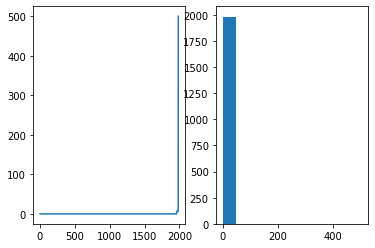

In [12]:
LRsort = sorted(LR)

fig4, axLRsorted = plt.subplots(1,2)
axLRsorted[0].plot(LRsort)
axLRsorted[1].hist(LRsort)

print(np.median(LR))

plt.show()

In [13]:
def U(x, xj, k):
    return sorted(range(len(x)-1), key = lambda i : la.norm(xj - x[i]), reverse=False)[1:k+1]

[1, 2, 18, 3, 17] [19 36 36 51 51]


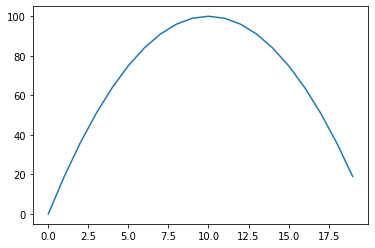

In [14]:
# U testing
test = 100 - (np.arange(0,20,1)-10) ** 2
print(U(test,0,5), test[U(test,0,5)])

plt.plot(test)
plt.show()

In [15]:
# conditional distance
def dc(x, j, t, k):
    u = U(x, x[j], k)
    
    # print(u)
    
    D = 0
    K = k
    for l in u:
        if j+t < x.shape[0] and l+t < x.shape[0]:
            D += la.norm(x[j+t] - x[l+t])
        else:
            print("cannot access element")
            k -= 1
    
    return D / K

# neighbor distance
def d(x, j, k):
    u = U(x, x[j], k)
    
    D = 0
    for l in u:
        D += la.norm(x[j] - x[l])
    
    return D / k

In [16]:
# distance tests
print(test[U(test,test[0],5)])
print(d(test, 0, 5))
print(dc(test, 0, 2, 5))

unif = np.ones(50)
print(d(unif, 4, 10))
print(dc(unif, 4, 5, 10))

[19 36 36 51 51]
38.6
cannot access element
19.8
0.0
0.0


In [17]:
# dynamic similarity
def S(x, j, t, k):
    return d(x, j, k) / dc(x, j, t, k)

cannot access element


C:\Users\Kenneth\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Kenneth\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


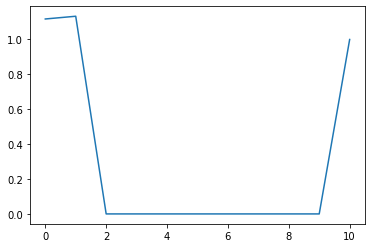

In [18]:
s = np.zeros(test.shape[0])
for i in range(len(s)):
    s[i] = S(test, i, 1, 1)
    
plt.plot(s)
plt.show()

In [19]:
def flus(x, k, low, upp):
    s = np.zeros(upp-low)
    for i in range(low,upp):
        s[i-low] = S(x, i, 1, k)
    
    mus = sum(s) / (upp - low)
    
    fl = sum( (s-mus)**2 )
    return fl

In [20]:
print(flus(X, 5, 0, 19))
winSize = 100
"""
FlucOfSim = np.zeros(tlen - winSize)
for i in range(FlucOfSim.shape[0]):
    FlucOfSim[i] = flus(X, 20, i, i+winSize)
    print(FlucOfSim[i])
"""

0.62647795611122


'\nFlucOfSim = np.zeros(tlen - winSize)\nfor i in range(FlucOfSim.shape[0]):\n    FlucOfSim[i] = flus(X, 20, i, i+winSize)\n    print(FlucOfSim[i])\n'

In [21]:
"""
fig, axs = plt.subplots(2,1)

axs[0].plot(X)
axs[1].plot(FlucOfSim)
plt.show()
"""

'\nfig, axs = plt.subplots(2,1)\n\naxs[0].plot(X)\naxs[1].plot(FlucOfSim)\nplt.show()\n'

In [59]:
# Slow Feature Analysis

def hprime(x):
    n = x.shape[0]
    d = x.shape[1]
    
    M = int(d+d*(d+1)/2) # number of monomials and binomials
    
    hx = np.zeros((n,M))
    hx[:,0:d] = x
    ind = d
    for i in range(d):
        xi = x[:,i]
        for j in range(i,d):
            xj = x[:,j]
            hx[:,ind] = np.multiply(xi, xj)
            ind += 1
            
    return hx

def standardize(x):
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

In [70]:
np.set_printoptions(precision=4, suppress=True)
# print("X = ", X.shape)
Xst = standardize(X)
# print(Xst.shape, hp.shape)
# zprime = Xst
zprime = hprime(Xst)
c = np.cov(zprime.T, bias=False)
print("Covariance = ", c, c.shape)

eigval, eigvec = la.eig(c)
# print("Eigenstuff = ", eigval, eigvec)

diagEigVal = np.diag((eigval) ** -0.5) #  

print(zprime.shape, diagEigVal.shape, eigvec.T.shape)
z = zprime @ (eigvec @ diagEigVal)
# z = np.real(z)
print("z = ", z)
print("Mean test(should be 0)", np.mean(z))
print("Covariance test(should be I): \n",np.cov(z.T))

Covariance =  [[ 1.0005  0.8876 -0.0363 ... -0.0142 -0.0119 -0.0028]
 [ 0.8876  1.0005 -0.0361 ...  0.017   0.0144  0.0177]
 [-0.0363 -0.0361  1.0005 ...  0.1406  0.1081  0.1275]
 ...
 [-0.0142  0.017   0.1406 ...  1.36    1.1717  1.0407]
 [-0.0119  0.0144  0.1081 ...  1.1717  1.214   1.2172]
 [-0.0028  0.0177  0.1275 ...  1.0407  1.2172  1.3701]] (189, 189)
(1985, 189) (189, 189) (189, 189)
z =  [[    1.3093     1.1677     3.7507 ... -2286.2628 -2629.5356  1045.6577]
 [   -0.0206     0.0679     2.7959 ... -2282.7902 -2629.6301  1044.435 ]
 [   -1.1511    -0.2034     0.9552 ... -2283.6798 -2631.1974  1043.8881]
 ...
 [    1.0376     1.7246     1.1938 ... -2285.6686 -2629.7476  1044.5423]
 [    0.907      0.9593     1.455  ... -2284.1184 -2629.9298  1045.0646]
 [    0.6026     0.3563     1.1483 ... -2283.6942 -2629.7259  1045.5718]]
Mean test(should be 0) 15.797323911258651
Covariance test(should be I): 
 [[ 1.      0.     -0.     ... -0.     -0.      0.    ]
 [ 0.      1.      0.     .

In [67]:
zdot = z[1:,:] - z[:-1,:]

# print((zdot @ zdot.T).round(4))
eigValDot, eigVecDot = la.eig(zdot.T @ zdot)
print("EigenVectors = ", eigVecDot)
print(eigValDot)

a = eigVecDot[:,np.argsort(eigValDot)[0]] # eigVecDot.sort(key=eigValDot)[0]
print(a)
yt = a @ z.T
print(a.shape, z.shape)

EigenVectors =  [[-0.0001 -0.0001 -0.0004 ...  0.0149 -0.0022 -0.0116]
 [ 0.0005 -0.0003 -0.0004 ... -0.4772 -0.1708  0.0556]
 [-0.0001 -0.0001 -0.0002 ... -0.2355  0.0757  0.0597]
 ...
 [-0.0009 -0.0123  0.0001 ...  0.0136 -0.0214  0.0002]
 [ 0.0049 -0.0205 -0.0081 ... -0.018  -0.0701 -0.0078]
 [-0.0001 -0.0007 -0.0014 ... -0.055  -0.1485  0.01  ]]
[7874.073  7850.6508 7771.0925 7711.9396 7698.4906 7691.3319 7576.3214
 7502.742  7427.9468 7407.4775 7369.4703 7306.0074 7167.2566 7122.954
 7037.9776 7055.9295 6977.2512 6957.2202 6937.2386 6760.1186 6404.2818
 6661.5923 6618.4392 6551.3508 6694.6507 6320.9362 6266.4479 6252.8631
 6198.0924 6137.0757 6089.5015 5496.0388 6021.5391 6012.4382 5896.2906
 5581.9277 5847.1485 5813.1171 5725.2337 5638.152  5668.9859 5443.9534
 5321.7365 5397.4552 5089.833  5163.4226 5204.3523 5284.7261 4985.2492
 5248.7048 4842.5625 4878.4627 4892.3715 4784.4461 4723.3855 4625.6956
 4581.209  4681.4727 4484.4558 4427.6742 4390.1614 4363.7538 4261.989
 4190.8134 

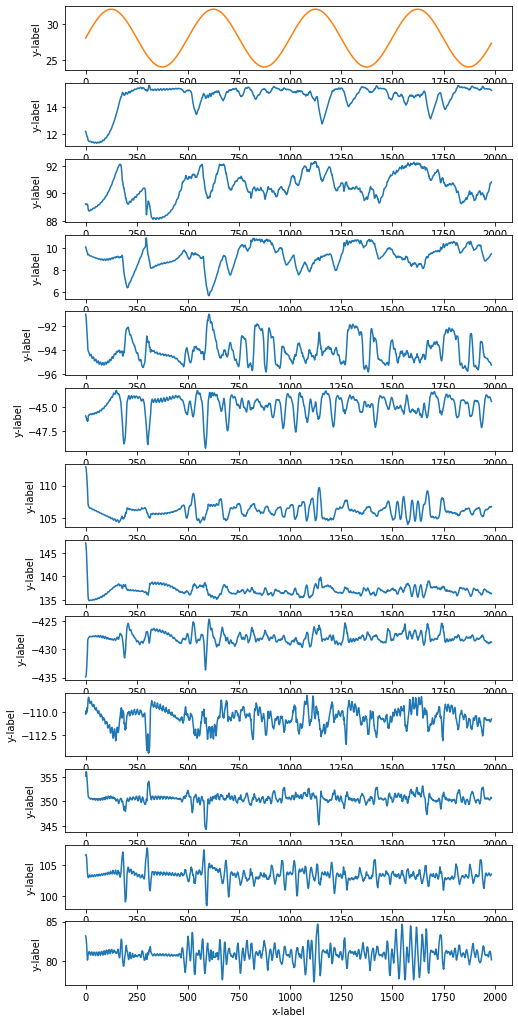

In [69]:
# gts = np.fromfunction(lambda i : r(i), yt.shape, dtype = float)# time series of gmax

# gts = np.fromfunction(lambda i : Gmax(i), yt.shape, dtype = float)# time series of gmax
gts = np.fromfunction(lambda i : rho(i), yt.shape, dtype = float)# time series of gmax

E = 12 #len(eigValDot)
fig, axs = plt.subplots(E+1,figsize=(8,E*1.5))
axs[0].plot(gts, c="tab:orange")

# print(ae.shape, z.T.shape)
for e in range(E):
    ae = eigVecDot[:,np.argsort(eigValDot)[e]]
    axs[e+1].plot(ae @ z.T)

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')


# plt.plot(yt)

plt.show()